For citation information, please see the "Source Information" section listed in the associated README file: https://github.com/stephbuon/digital-history/tree/master/hist3368-week12-word-context-vectors

# Hist 3368 - Week 12: Word Context Vectors with Gensim

## Teaching Version

#### By Jo Guldi

In [17]:
import pandas as pd
import csv
import glob
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import scipy.spatial.distance
import matplotlib
import matplotlib.pyplot as plt
import itertools
import gensim
import multiprocessing
from nltk.tokenize import sent_tokenize
from nltk.tokenize.treebank import TreebankWordTokenizer

In [218]:
def structure_data(sentences, lemma, stopwords, stemmed):

    # smoosh everything together
    one_string = ' '.join(sentences)
    
    # break it into sentences 
    sentences =  sent_tokenize(one_string) 
    
    # tokenize documents with gensim's tokenize() function
    token_list = [list(gensim.utils.tokenize(sent, lower=True)) for sent in sentences]
    
    # build bigram model
    bigram_mdl = gensim.models.phrases.Phrases(token_list, min_count=1, threshold=2)

    # lemmatize the tokens
    if lemma == True:
        pool = multiprocessing.Pool()
        token_list =  pool.map(lemmatize_column, token_list) #[[wn.morphy(item) for item in list] for list in token_list] 
        token_list = [[item for item in list if item is not None] for list in token_list] 
    token_list[0][:15]

    # remove stopwords and/or do stemming
    from gensim.parsing.preprocessing import preprocess_string#, remove_stopwords#, #stem_text
    CUSTOM_FILTERS = []
    if stopwords == True:
        from gensim.parsing.preprocessing import remove_stopwords
        CUSTOM_FILTERS.append(remove_stopwords)
    if stemmed == True:
        from gensim.parsing.preprocessing import stem_text
        CUSTOM_FILTERS.append(stem_text)
        
    processed = [preprocess_string(" ".join(word), CUSTOM_FILTERS) for word in token_list]
    #processed = [[item for item in list if item] for list in processed]

    # apply bigram model to list
    result = [bigram_mdl[item] for item in processed]
    
    return(result)
   

#### Load some Data

In [6]:
cd /scratch/group/history/hist_3368-jguldi

/scratch/group/history/hist_3368-jguldi


In [219]:
congress = pd.read_csv("congress1967-2010.csv")
all_data = congress[congress['year'] >= 1967]
all_data = congress[congress['year'] <= 1983]
#congress = pd.read_csv("eighties_data.csv")

FileNotFoundError: [Errno 2] File b'congress1967-2010.csv' does not exist: b'congress1967-2010.csv'

In [8]:
all_data[:5]

,Unnamed: 0,Unnamed: 0.1,speech,date,speaker,word_count,year,month,month_year
0,0,0,Those who do not enjoy the privilege of the fl...,1967-01-10,The VICE PRESIDENT,16,1967,1,1967-01-01
1,1,1,Mr. President. on the basis of an agreement re...,1967-01-10,Mr. MANSFIELD,35,1967,1,1967-01-01
2,2,2,The Members of the Senate have heard the remar...,1967-01-10,The VICE PRESIDENT,40,1967,1,1967-01-01
3,3,3,The Chair lays before the Senate the following...,1967-01-10,The VICE PRESIDENT,151,1967,1,1967-01-01
4,4,4,Secretary of State.,1967-01-10,Mrs. AGNES BAGGETT,3,1967,1,1967-01-01


In [9]:
all_data['5yrperiod'] = np.floor(all_data['year'] / 5) * 5 # round each year to the nearest 5 -- by dividing by 5 and "flooring" to the lowest integer
all_data = all_data.drop(['date', 'year', 'speaker','Unnamed: 0', 'Unnamed: 0.1', 'word_count', 'month'], 1)

/hpc/applications/anaconda/3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [10]:
all_data['index'] = np.arange(len(all_data)) # create an 'index' column

In [11]:
all_data.head()

,speech,month_year,5yrperiod,index
0,Those who do not enjoy the privilege of the fl...,1967-01-01,1965.0,0
1,Mr. President. on the basis of an agreement re...,1967-01-01,1965.0,1
2,The Members of the Senate have heard the remar...,1967-01-01,1965.0,2
3,The Chair lays before the Senate the following...,1967-01-01,1965.0,3
4,Secretary of State.,1967-01-01,1965.0,4


#### Downsample

In [12]:
sample_l = all_data.sample(500000)
sample_m = sample_l.sample(50000)
sample = sample_m.sample(5000)

## Introducing Gensim, a Tool for Studying Word Embeddings

In [220]:
sentences = structure_data(all_data['speech'], lemma = False, stopwords = True, stemmed = True) # <---- switch out sample_l to all_data, sample_s or sample_m here

TypeError: 'list' object is not callable

In [112]:
sentences[:5]

[['enjoi', 'privileg', 'floor', 'retir', 'chamber'],
 ['mr_presid',
  'basi',
  'agreement',
  'reach',
  'side',
  'suggest',
  'chamber',
  'clear',
  'attach',
  'absolut',
  'import',
  'busi',
  'attend',
  'chamber'],
 ['member',
  'senat',
  'heard',
  'remark',
  'distinguish',
  'major',
  'leader',
  'attach',
  'staff_member',
  'vital',
  'need',
  'minut',
  'deliber',
  'senat',
  'tetir',
  'chamber'],
 ['chair',
  'lai',
  'senat',
  'follow',
  'matter',
  'copi',
  'resign',
  'senat',
  'virginia',
  'mr',
  'robertson',
  'cxiii',
  'certif',
  'appoint',
  'william_b',
  'spong_jr',
  'vacanc',
  'shortterm',
  'certif',
  'robert_p',
  'griffin',
  'michigan',
  'credenti',
  'senatorsnam',
  'harri',
  'f_byrd',
  'jr',
  'virginia',
  'ernest_f',
  'holl',
  'south',
  'carolinaelect',
  'novemb',
  'unexpir',
  'term',
  'credenti',
  'senat',
  'elect',
  'year',
  'term',
  'begin',
  'd',
  'dai',
  'januari',
  'chair',
  'advis',
  'certif',
  'senat',
  '

In [122]:
congress_model = gensim.models.Word2Vec(
    sentences = sentences,
    #workers= 29, # if you have more computing power available
    min_count = 10, # remove words stated only once
    size = 100) # size of neuralnet layers; default is 100; higher for larger corpora

#### Use the lines below to save the model for later use or to load a saved model

In [123]:
#congress_model.save('congress_model')

In [124]:
#congress_model = gensim.models.Word2Vec.load('congress_model') 

#### Find the CONTEXT for One Word

In [125]:
man_vector = congress_model.wv['man']
congress_model.wv.similar_by_vector(man_vector)

[('man', 1.0),
 ('manand', 0.8365031480789185),
 ('men', 0.780304491519928),
 ('mana', 0.7518138885498047),
 ('unpretenti', 0.7504839897155762),
 ('honest_man', 0.7212955355644226),
 ('selfeffac', 0.7204166650772095),
 ('decent_man', 0.71869295835495),
 ('brilliant_man', 0.7150098085403442),
 ('rog_morton', 0.7149184942245483)]

In [128]:
woman_vector = congress_model.wv['woman']
congress_model.wv.similar_by_vector(woman_vector)

[('woman', 0.9999999403953552),
 ('young_man', 0.7728546857833862),
 ('young_woman', 0.7281596064567566),
 ('mother', 0.7269006967544556),
 ('young_girl', 0.7092545032501221),
 ('wife_mother', 0.7075739502906799),
 ('husband', 0.7062862515449524),
 ('black_woman', 0.6997578144073486),
 ('yearold_man', 0.6875299215316772),
 ('grandmoth', 0.6820991039276123)]

In [133]:
individual_vector = congress_model.wv['person']
congress_model.wv.similar_by_vector(individual_vector)

[('person', 0.9999998807907104),
 ('individu', 0.8170316219329834),
 ('american_citizen', 0.6088587045669556),
 ('citizen', 0.5980047583580017),
 ('peopl', 0.5856267213821411),
 ('blind_person', 0.5684384107589722),
 ('client', 0.5654584169387817),
 ('men_women', 0.5616015195846558),
 ('man', 0.5591574907302856),
 ('woman', 0.5591350793838501)]

In [134]:
soldier_vector = congress_model.wv['soldier']
congress_model.wv.similar_by_vector(soldier_vector)

[('soldier', 1.0),
 ('american_soldier', 0.8059609532356262),
 ('men', 0.8050188422203064),
 ('young_soldier', 0.7806587815284729),
 ('infantrymen', 0.766939640045166),
 ('combat_soldier', 0.758751630783081),
 ('airmen', 0.7405596971511841),
 ('foot_soldier', 0.7280247211456299),
 ('paratroop', 0.7202160358428955),
 ('foxhol', 0.7095552682876587)]

In [146]:
congress_model.wv.most_similar("women", topn = 20)

[('young_women', 0.7401868104934692),
 ('femal', 0.7308927774429321),
 ('american_ort', 0.6976419687271118),
 ('male', 0.6926409006118774),
 ('young_men', 0.6849506497383118),
 ('white_male', 0.668535590171814),
 ('womenth', 0.6658964157104492),
 ('lib', 0.6584514379501343),
 ('adult_women', 0.6462479829788208),
 ('womenand', 0.6395845413208008),
 ('older_women', 0.6391816139221191),
 ('lesbian', 0.6370357275009155),
 ('woman', 0.6363738775253296),
 ('negro', 0.6336139440536499),
 ('men_women', 0.6284761428833008),
 ('poor_pregnant', 0.6231228113174438),
 ('childbear', 0.61910480260849),
 ('teenag', 0.6165823340415955),
 ('weaker_sex', 0.6163535714149475),
 ('maledomin', 0.6140998601913452)]

#### Interpreting vector similarity

Try your own hand at interpreting these outputs. 

How do you interpret these similarities?

In [150]:
congress_model.wv.most_similar("iraq", topn = 20)

[('iraqi', 0.8983794450759888),
 ('egypt_syria', 0.8314588069915771),
 ('libya', 0.8282959461212158),
 ('syria_egypt', 0.8093744516372681),
 ('syria', 0.8051905632019043),
 ('egypt', 0.805038332939148),
 ('iraq_syria', 0.7996413707733154),
 ('egyptian', 0.7961423397064209),
 ('iran', 0.7961345911026001),
 ('libya_iraq', 0.7927939891815186),
 ('pakistan', 0.7902470827102661),
 ('syria_lebanon', 0.7742722034454346),
 ('arab', 0.7738584280014038),
 ('colonel_qadhafi', 0.7732255458831787),
 ('saudi_arabia', 0.7613897323608398),
 ('jordanian', 0.7595088481903076),
 ('syrian', 0.7575228214263916),
 ('isra', 0.7565345168113708),
 ('iranian', 0.7534986734390259),
 ('pakistani', 0.7525876760482788)]

In [151]:
congress_model.wv.most_similar("america", topn = 20)

[('americath', 0.8190011978149414),
 ('americaand', 0.7278441786766052),
 ('nationth', 0.7277538180351257),
 ('countri', 0.7244937419891357),
 ('worldth', 0.7229493856430054),
 ('nation', 0.720410168170929),
 ('american', 0.6882414817810059),
 ('nationand', 0.6680247783660889),
 ('world', 0.650959312915802),
 ('worlda', 0.6454141736030579),
 ('entir_world', 0.6389248967170715),
 ('vibrant', 0.6286383867263794),
 ('western_world', 0.6281250715255737),
 ('americaa', 0.6270239353179932),
 ('world_wai', 0.6219524145126343),
 ('countryand', 0.6216217875480652),
 ('americato', 0.6216146349906921),
 ('countryth', 0.6143407821655273),
 ('free_men', 0.6075674295425415),
 ('worldon', 0.6066341400146484)]

In [152]:
congress_model.wv.most_similar("britain", topn = 20)

[('great_britain', 0.8992128372192383),
 ('franc', 0.843681812286377),
 ('england', 0.8102517127990723),
 ('british', 0.793901801109314),
 ('french', 0.7694352269172668),
 ('austria', 0.7258840799331665),
 ('west_german', 0.7254773378372192),
 ('french_italian', 0.7152698040008545),
 ('finland', 0.7139995098114014),
 ('dutch', 0.7114557027816772),
 ('algeria', 0.7104916572570801),
 ('spain', 0.7056548595428467),
 ('iceland', 0.7037515640258789),
 ('japan', 0.6999384164810181),
 ('itali', 0.6991938948631287),
 ('belgian', 0.6890571713447571),
 ('netherland', 0.6839677095413208),
 ('germani', 0.6819546818733215),
 ('napoleon_iii', 0.6813606023788452),
 ('denmark', 0.6784582734107971)]

## Subtracting Vectors

In [135]:
diff = congress_model.wv['man'] - congress_model.wv['woman']
congress_model.wv.similar_by_vector(diff)

[('man', 0.5213268995285034),
 ('rugged', 0.48694831132888794),
 ('uner', 0.48492029309272766),
 ('unassum', 0.47534114122390747),
 ('good_humor', 0.47522807121276855),
 ('unostentati', 0.47228366136550903),
 ('amiabl', 0.46221089363098145),
 ('rectitud', 0.4615515470504761),
 ('scoop_jackson', 0.4599013030529022),
 ('grandeur', 0.45736634731292725)]

In [136]:
diff = congress_model.wv['woman'] - congress_model.wv['boy']
congress_model.wv.similar_by_vector(diff)

[('woman', 0.9974225163459778),
 ('young_man', 0.7618976831436157),
 ('mother', 0.72350013256073),
 ('young_woman', 0.7088172435760498),
 ('young_girl', 0.6986392736434937),
 ('husband', 0.6886535882949829),
 ('wife_mother', 0.6871700286865234),
 ('black_woman', 0.6807257533073425),
 ('yearold_man', 0.668562650680542),
 ('grandmoth', 0.6619118452072144)]

In [138]:
diff = congress_model.wv['peopl'] - congress_model.wv['person']
congress_model.wv.similar_by_vector(diff)

[('peopl', 0.6033751964569092),
 ('peopleand', 0.5245252847671509),
 ('turn_back', 0.5190672874450684),
 ('countrysid', 0.5179525017738342),
 ('cry', 0.49867379665374756),
 ('hungri', 0.4984903931617737),
 ('rest', 0.496820330619812),
 ('hinterland', 0.4912468194961548),
 ('heartland', 0.49036338925361633),
 ('breadbasket', 0.4894271492958069)]

In [139]:
diff = congress_model.wv['person'] - congress_model.wv['peopl']
congress_model.wv.similar_by_vector(diff)

[('therewith', 0.5091977119445801),
 ('pecuniari', 0.5088791847229004),
 ('shall_contain', 0.5042147636413574),
 ('nondisclosur', 0.4997200071811676),
 ('disqualif', 0.49112626910209656),
 ('precomplaint', 0.4839070439338684),
 ('hereund', 0.4815957844257355),
 ('extrajudici', 0.4811444580554962),
 ('aforement', 0.4801686406135559),
 ('dodd', 0.4782324731349945)]

In [140]:
diff = congress_model.wv['think'] - congress_model.wv['heart']
congress_model.wv.similar_by_vector(diff)

[('think', 0.6633435487747192),
 ('obvious', 0.5485060214996338),
 ('suggest', 0.5446309447288513),
 ('believ', 0.5291328430175781),
 ('certainli', 0.5162572264671326),
 ('ought', 0.5120036005973816),
 ('absolut', 0.49281981587409973),
 ('understand', 0.4743674695491791),
 ('judgment', 0.46895357966423035),
 ('sure', 0.4568883180618286)]

In [141]:
diff = congress_model.wv['feel'] - congress_model.wv['think']
congress_model.wv.similar_by_vector(diff)

[('deep_distress', 0.5066766738891602),
 ('deepest_sorrow', 0.47855573892593384),
 ('deep_concern', 0.4535718858242035),
 ('undersign', 0.44980448484420776),
 ('heartfelt_sorrow', 0.44788962602615356),
 ('heartfelt_concern', 0.4416431486606598),
 ('y_courier', 0.4372115731239319),
 ('profound_concern', 0.43565672636032104),
 ('deepfelt', 0.43363243341445923),
 ('sorrow_shock', 0.42603906989097595)]

### Adding vectors to find synonyms

In [155]:
keyword_context = [word[0] for word in congress_model.wv.most_similar("women", topn = 100)]

sum = congress_model.wv[keyword_context[0]] 

for word in keyword_context[1:len(keyword_context)]:
    next_vector = congress_model.wv[word] 
    sum = sum + next_vector
    
congress_model.wv.similar_by_vector(sum)

[('women', 0.8543922901153564),
 ('white_male', 0.8205428123474121),
 ('teenag', 0.8094397783279419),
 ('femal', 0.7965259552001953),
 ('young_women', 0.794630765914917),
 ('male', 0.7928563952445984),
 ('adult_women', 0.7880475521087646),
 ('negro_youth', 0.7719589471817017),
 ('negro', 0.7632759809494019),
 ('black_male', 0.7546308040618896)]

In [156]:
keyword_context = [word[0] for word in congress_model.wv.most_similar("soldier", topn = 100)]
sum = congress_model.wv[keyword_context[0]] 
for word in keyword_context[1:len(keyword_context)]:
    next_vector = congress_model.wv[word] 
    sum = sum + next_vector
congress_model.wv.similar_by_vector(sum)

[('soldier', 0.912670373916626),
 ('paratroop', 0.8429803848266602),
 ('american_soldier', 0.8310208916664124),
 ('airmen', 0.8310191631317139),
 ('young_soldier', 0.8166890740394592),
 ('infantrymen', 0.8160274028778076),
 ('combat_soldier', 0.8051732778549194),
 ('negro_soldier', 0.8040686249732971),
 ('foot_soldier', 0.8038418292999268),
 ('khe_sanh', 0.7980746030807495)]

In [164]:
keyword_context = [word[0] for word in congress_model.wv.most_similar("happi", topn = 100)]
sum = congress_model.wv[keyword_context[0]] 
for word in keyword_context[1:len(keyword_context)]:
    next_vector = congress_model.wv[word] 
    sum = sum + next_vector
congress_model.wv.similar_by_vector(sum)

[('happi', 0.7953307032585144),
 ('grate', 0.7675093412399292),
 ('warmth_friendship', 0.7544974088668823),
 ('delight', 0.751697301864624),
 ('joi', 0.7437549233436584),
 ('warmest', 0.736836314201355),
 ('warm', 0.7342638969421387),
 ('warm_friendship', 0.7336139678955078),
 ('wife_albra', 0.7265288829803467),
 ('graciou', 0.724779486656189)]

In [165]:
keyword_context = [word[0] for word in congress_model.wv.most_similar("american", topn = 100)]
sum = congress_model.wv[keyword_context[0]] 
for word in keyword_context[1:len(keyword_context)]:
    next_vector = congress_model.wv[word] 
    sum = sum + next_vector
congress_model.wv.similar_by_vector(sum)

[('american', 0.829459547996521),
 ('men_women', 0.7907873392105103),
 ('countrymen', 0.780424952507019),
 ('compatriot', 0.7803544998168945),
 ('fellow_citizen', 0.7793393135070801),
 ('america', 0.7711617946624756),
 ('fellow_countrymen', 0.7558329105377197),
 ('peoplea', 0.7407668828964233),
 ('peopl', 0.7389375567436218),
 ('american_citizen', 0.7334094047546387)]

### Distance and Similarity with Vectors in GENSIM

With similarity, the higher the number, the more alike two terms are in the context in which they are used. 

In [166]:
congress_model.wv.similarity('women', 'men')

0.5170834

In [167]:
congress_model.wv.similarity('soldier', 'men')

0.8050189

In [168]:
congress_model.wv.similarity('women', 'person')

0.3511137

#### Visualize the similarities as a Dendrogram

In [196]:
keywords = ['dream',  'war',  'wealth', 'happi',  'tomorrow', 'past', 'present', 'futur', 'america',  'britain', 'china', 'democrat', 'welfar', 'commun', 'russia', 'congress', 'protest']

In [197]:
keyword_vectors = congress_model.wv[keywords]

In [198]:
from scipy.cluster.hierarchy import dendrogram, linkage
links = linkage(keyword_vectors, method='complete', metric='seuclidean')

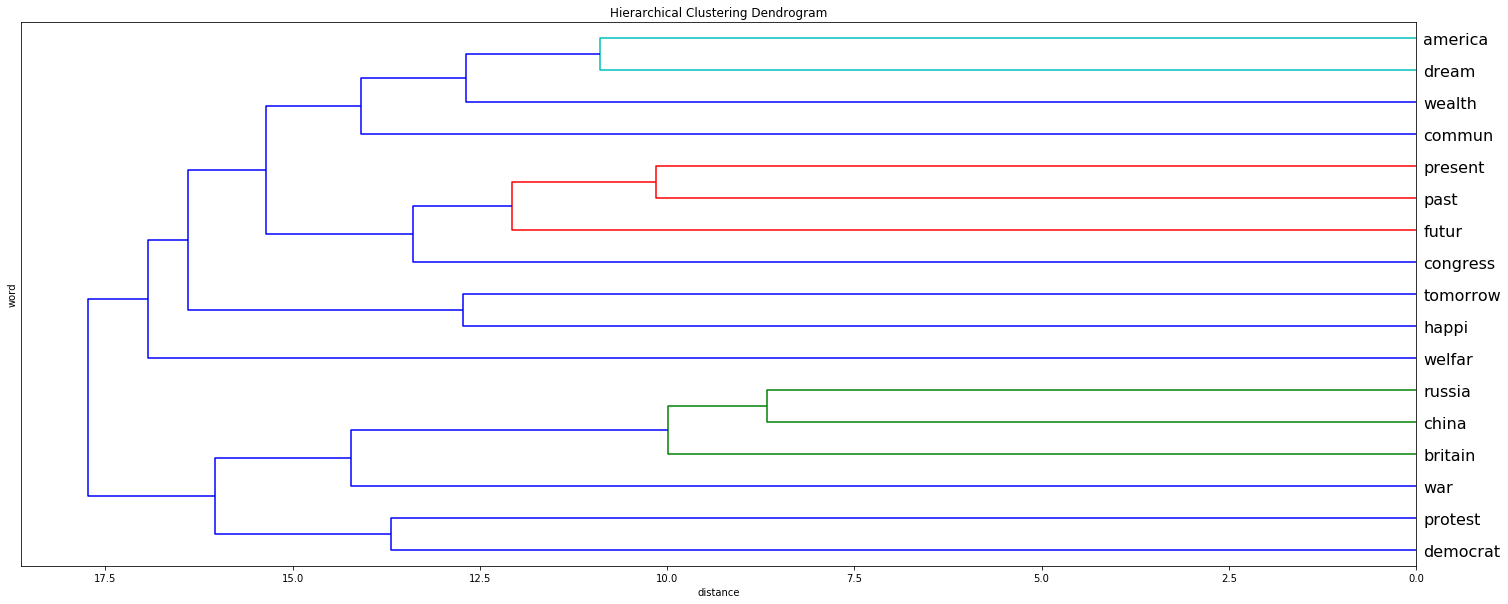

In [199]:
from matplotlib import pyplot as plt

l = links

# calculate full dendrogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.ylabel('word')
plt.xlabel('distance')

dendrogram(
    l,
    leaf_rotation=0,  # rotates the x axis labels
    leaf_font_size=16,  # font size for the x axis labels
    orientation='left',
    leaf_label_func=lambda v: str(keywords[v])
)
plt.show()


*Note: if you get an error above, delete any words from the list.*

### Visualizing Abstract Relatedness

In [200]:
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.decomposition import PCA
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors

In [201]:
#%matplotlib inline

def display_pca_scatterplot(model, words=None, sample=0):
    if words == None:
        if sample > 0:
            words = np.random.choice(list(model.wv.vocab.keys()), sample)
        else:
            words = [ word for word in model.wv.vocab ]
        
    word_vectors = np.array([model[w] for w in words])

    twodim = PCA().fit_transform(word_vectors)[:,:2]
    
    plt.figure(figsize=(6,6))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
    for word, (x,y) in zip(words, twodim):
        plt.text(x+0.05, y+0.05, word)

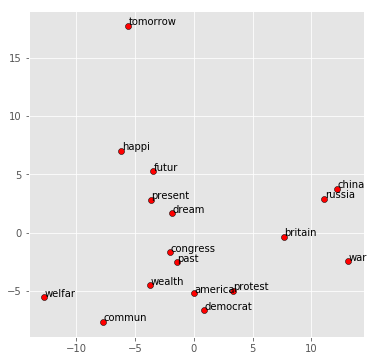

In [202]:
display_pca_scatterplot(congress_model.wv, keywords)

## Research the Changing Context of One Keyword Over Time with GENSIM

#### Make a word embedding model per period

In [203]:
dataname = 'sample-m'

In [206]:
periodnames = all_data['5yrperiod'].unique()

In [207]:
cd '/scratch/group/history/hist_3368-jguldi/congress-embeddings'

/scratch/group/history/hist_3368-jguldi/congress-embeddings


In [208]:
for period1 in periodnames:
    print('working on ', period1)

    # grab the data from period1
    period_data = sample_m[sample_m['5yrperiod'] == period1] # select one period at a time
    
    # structure the data for Gensim
    period_sentences = structure_data(period_data['speech'], lemma = False, stopwords = True, stemmed = True)
    
    # make the Gensim model
    period_model = gensim.models.Word2Vec( # make a gensim model for that data
        sentences = period_sentences,
        min_count = 2, 
        size = 100)
    
    # save it
    period_model.save(dataname + '-model-' + str(period1)) # save the model with the name of the period


working on  1965.0
mining  1965.0
working on  1970.0
mining  1970.0
working on  1975.0
mining  1975.0
working on  1980.0
mining  1980.0


#### Search each 5-year model for a keyword.

In [209]:
keyword1 = 'black'

In [210]:
#########  after the first run, use this line to call the old data without generating it again
keyword_context = []
dates_found = []

# cycle through each period
for period1 in periodnames:
    print('working on ', period1)
    
    # load the model from period1
    period_model = gensim.models.Word2Vec.load(dataname + '-model-' + str(period1)) # to load a saved model

    ## is the keyword found?
    if keyword1 in period_model.wv.vocab:
        print('found ', keyword1)
        
        # get the context vector for keyword1
        keyword_context_period = period_model.wv.most_similar(keyword1, topn = 5000) 
        
        # save it for later
        keyword_context.append(keyword_context_period) # save the context of how women were talked about for later
        dates_found.append(period1)

working on  1965.0
found  black
working on  1970.0
found  black
working on  1975.0
found  black
working on  1980.0
found  black


#### Visualize it

In [211]:
# helper function to abstract only unique values while keeping the list in the same order -- the order of first appearance
def unique2(seq):
    seen = set()
    seen_add = seen.add
    return [x for x in seq if not (x in seen or seen_add(x))]

In [212]:
all_words = []
for i in range(len(dates_found)):
    words = [item[0] for item in keyword_context[i]][:10]
    all_words.append(words)

all_words2 = []
for list in all_words:
    for word in list:
        all_words2.append(word)

numwords = 10


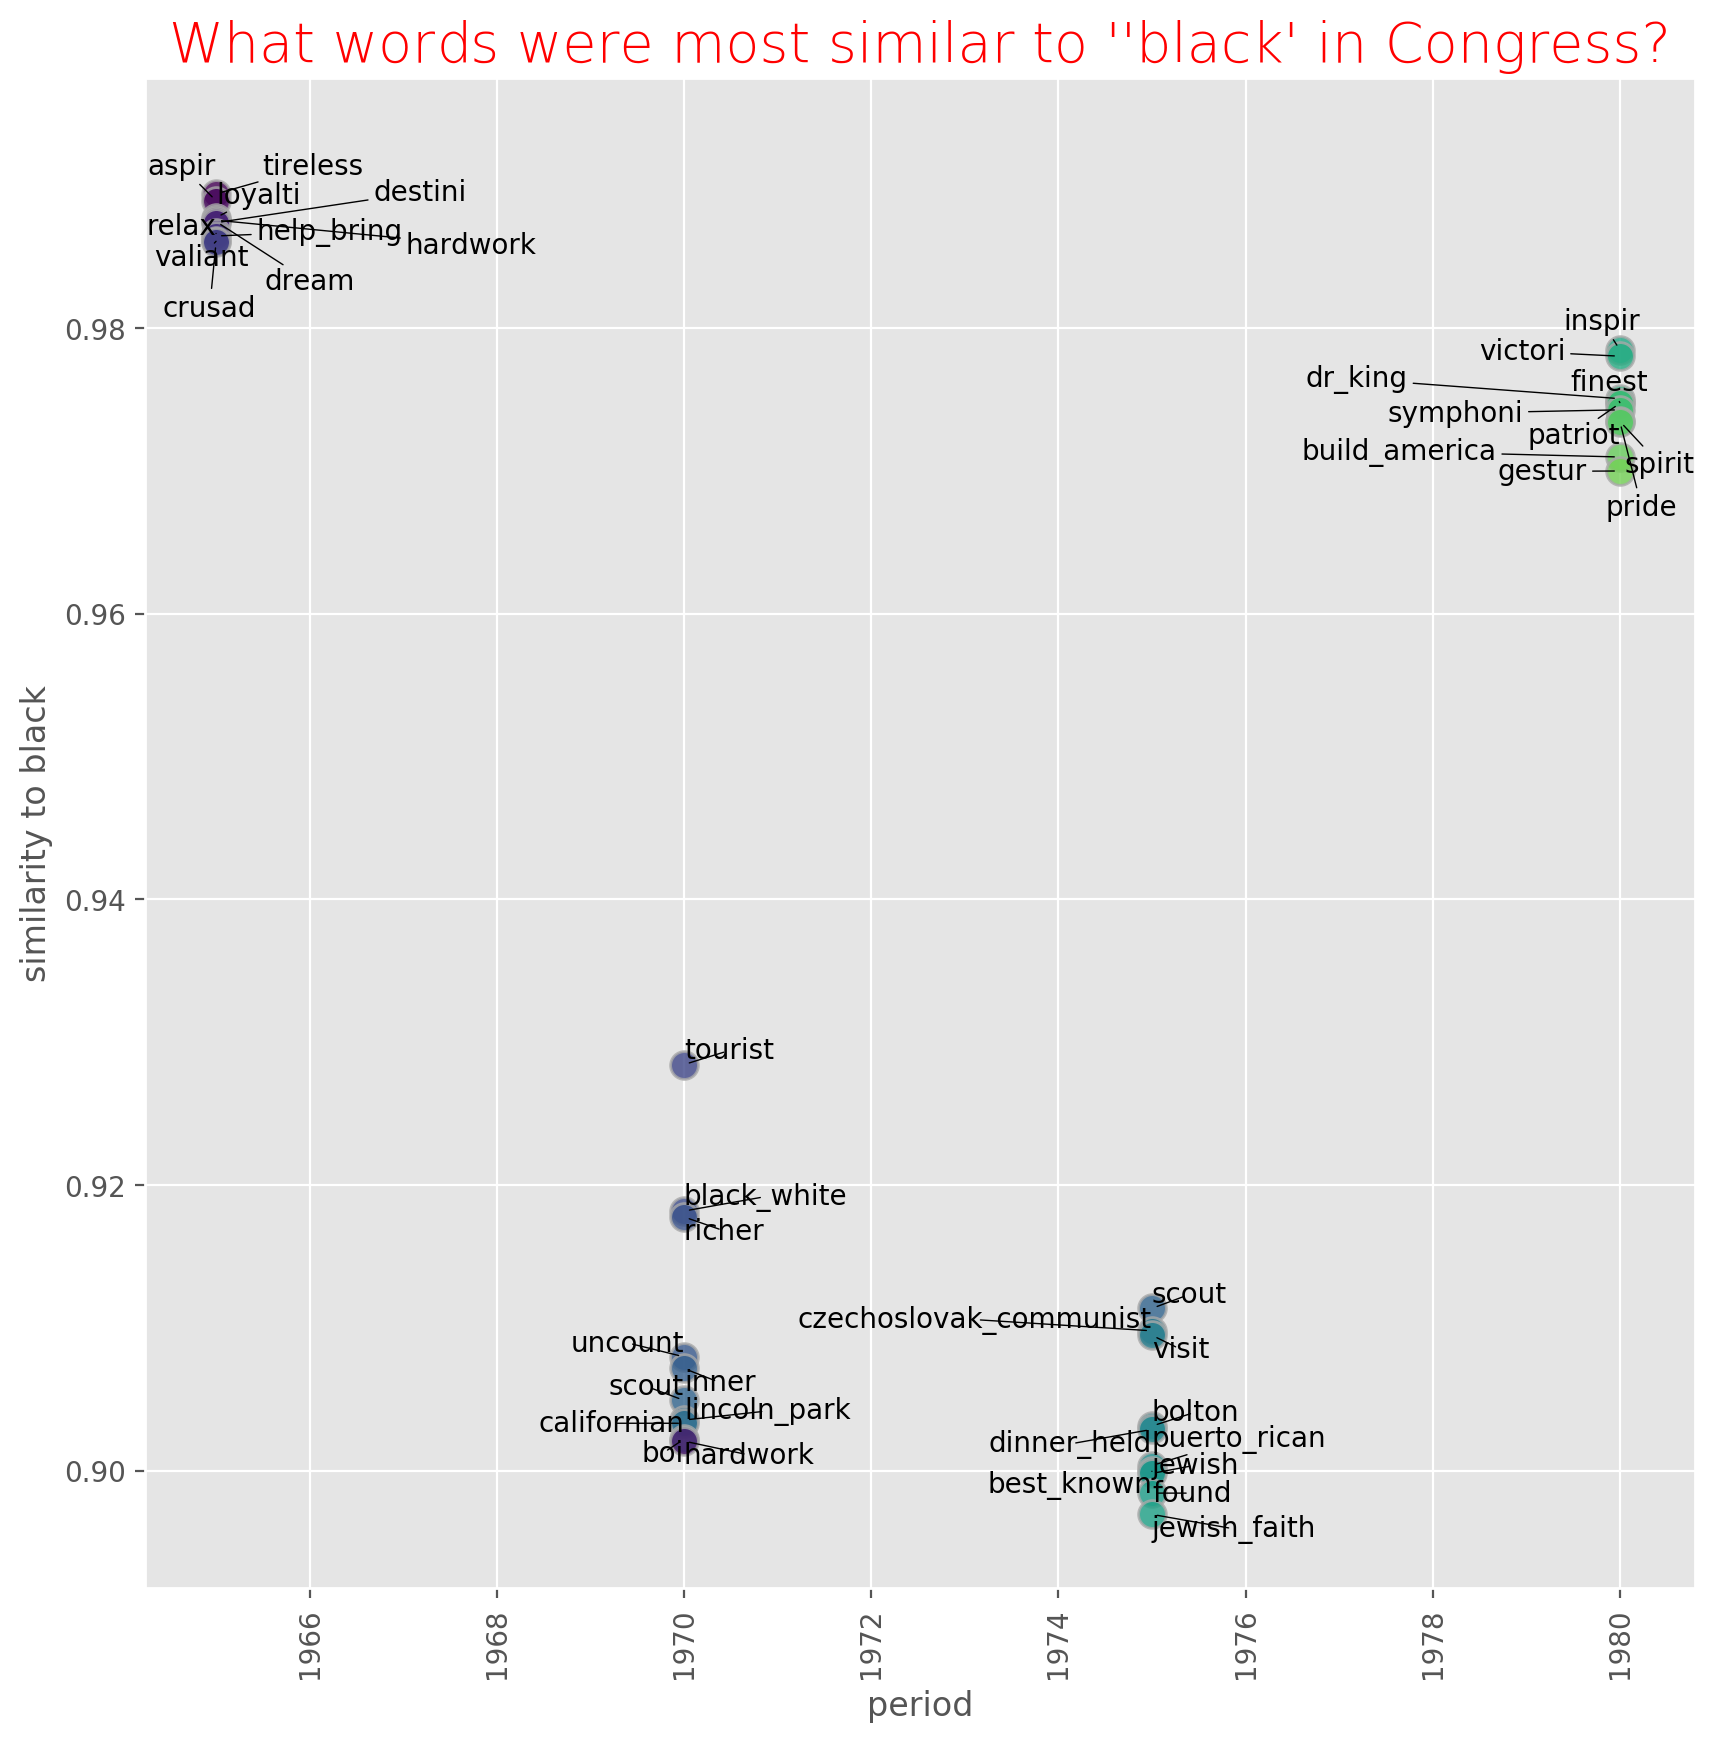

In [217]:
%matplotlib inline
#from matplotlib.colors import ListedColormap, LinearSegmentedColormap

from adjustText import adjust_text
from numpy import linspace
from matplotlib import cm

colors = [ cm.viridis(x) for x in linspace(0, 1, len(unique2(all_words2))+10) ]

# change the figure's size here
plt.figure(figsize=(10,10), dpi = 200)

texts = []

# plt.annotate only plots one label per iteration, so we have to use a for loop 
for i in range(len(dates_found)):    # cycle through the period names
    
    #yyy = int(keyword_per_year[keyword_per_year['5yrperiod'] == int(xx)]['count'])   # how many times was the keyword used that year?
                     
    for j in range(10):     # cycle through the first ten words (you can change this variable)
        
        xx = dates_found[i]        # on the x axis, plot the period name
        yy = [item[1] for item in keyword_context[i]][j]         # on the y axis, plot the distance -- how closely the word is related to the keyword
        txt = [item[0] for item in keyword_context[i]][j]        # grab the name of each collocated word
        colorindex = unique2(all_words2).index(txt)   # this command keeps all dots for the same word the same color
        
        plt.scatter(                                             # plot dots
            xx, #x axis
            yy, # y axis
            linewidth=1, 
            color = colors[colorindex],
            edgecolors = 'darkgray',
            s = 100, # dot size
            alpha=0.8)  # dot transparency

        # make a label for each word
        texts.append(plt.text(xx, yy, txt))

# Code to help with overlapping labels -- may take a minute to run
adjust_text(texts, force_points=0.2, force_text=.7, 
                    expand_points=(1, 1), expand_text=(1, 1),
                    arrowprops=dict(arrowstyle="-", color='black', lw=0.5))

plt.xticks(rotation=90)

# Add titles
plt.title("What words were most similar to ''" + keyword1 + "' in Congress?", fontsize=20, fontweight=0, color='Red')
plt.xlabel("period")
plt.ylabel("similarity to " + keyword1)


filename = 'words-similar-to-' + keyword1 + '-' + dataname
plt.savefig(filename)